In [35]:
import os
import cantera as ct
import numpy as np
import pandas as pd
import ess
import sys
sys.path.append(os.path.join(os.environ['UNCERTAINTY_REPO'], 'bpe', 'simulation'))  # Cantera simulation
import simulation
import yaml
import logging

In [36]:
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)


In [2]:
working_dir = '/scratch/harris.se/guassian_scratch/mk3_runs/ct_20260128'

In [3]:
sim_info_yaml = os.path.join(working_dir, 'sim_info.yaml')
with open(sim_info_yaml) as f:
    sim_info = yaml.safe_load(f)

In [25]:
sim_info

{'out_gas_indices': [4, 3, 7, 8, 5, 6],
 'out_gas_names': ['O2', 'CH4', 'H2', 'CO', 'CO2', 'H2O'],
 'parameter_names': ['O2(3) + 2 X(1) <=> 2 OX(25)',
  'CO(7) + X(1) <=> COX(23)',
  'H(12) + X(1) <=> HX(21)',
  'CO2(4) + X(1) <=> CO2X(22)',
  'CH3(10) + X(1) <=> CH3X(27)',
  'H2(6) + X(1) <=> H2X(30)',
  'OH(17) + X(1) <=> OHX(31)',
  'H2O(5) + X(1) <=> H2OX(32)'],
 'prior_reaction_indices': [0, 1, 2, 3, 4, 5, 13, 14],
 'prior_species_indices': [],
 'sample_distances': [0.0001,
  0.0007500000000000001,
  0.0014000000000000002,
  0.00205,
  0.0027,
  0.00335,
  0.004,
  0.0066,
  0.01]}

In [8]:
# laod chain and logP
chain0 = ess.flatten_chain(np.load(os.path.join(working_dir, 'results', 'chain_0.npy')))
chain1 = ess.flatten_chain(np.load(os.path.join(working_dir, 'results', 'chain_1.npy')))

chain = np.concatenate((chain0, chain1))

In [9]:
chain.shape

(2368, 8)

In [10]:
# laod chain and logP
logP0 = ess.flatten_logP(np.load(os.path.join(working_dir, 'results', 'logPs_0.npy')))
logP1 = ess.flatten_logP(np.load(os.path.join(working_dir, 'results', 'logPs_1.npy')))

logP = np.concatenate((logP0, logP1))

In [11]:
logP.shape

(2368,)

In [12]:
MAP_index = np.argmax(logP)

In [13]:
MAP_index

np.int64(663)

In [15]:
MAP_params = chain[MAP_index, :]

In [16]:
MAP_params

array([-0.48440635,  0.67928459,  0.56751652,  0.12967423,  0.10420388,
       -0.21008214,  0.98831498, -1.24442882])

In [38]:
mech_yaml = os.path.join(working_dir, 'chem_annotated.yaml')
gas = ct.Solution(mech_yaml)
surf = ct.Interface(mech_yaml, "surface1", [gas])

/tmp/ipykernel_2796473/1679060362.py:3: UserWarning: StickingRate::validate: 
Sticking coefficient is greater than 1 for reaction 'CH4(2) + 2 X(1) <=> CH3X(27) + HX(21)'
at T = 5000.0
at T = 10000.0

  surf = ct.Interface(mech_yaml, "surface1", [gas])


In [39]:
gas_out, surf_out, gas_rates, surf_rates = simulation.run_simulation(mech_yaml)

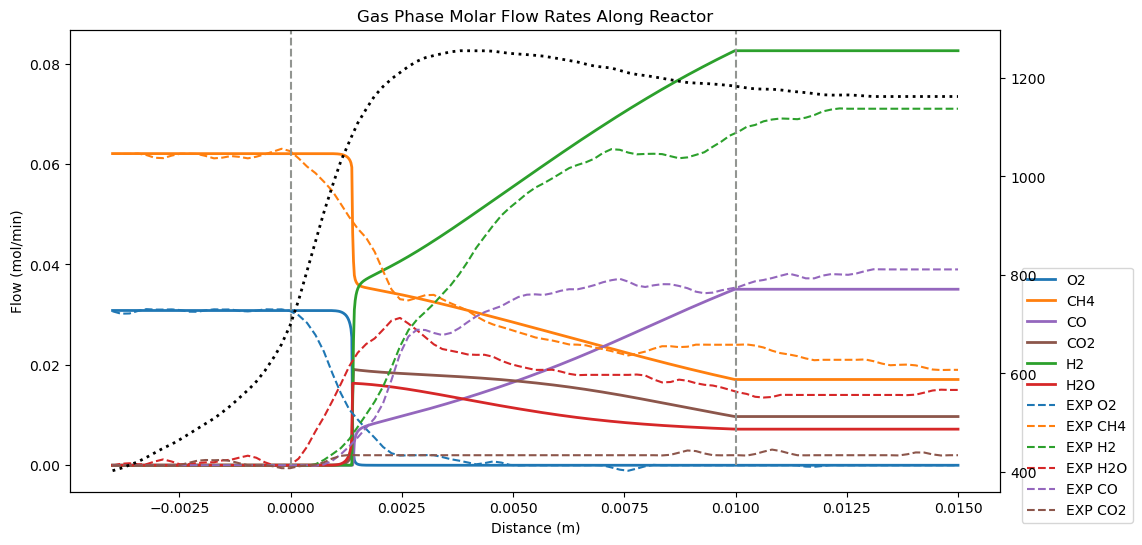

In [40]:
simulation.plot_gas_results(gas_out, gas)

In [41]:
kinetics_perturb = {}
for i in range(len(sim_info['prior_reaction_indices'])):
    kinetics_perturb[sim_info['prior_reaction_indices'][i]] = float(np.float_power(10, MAP_params[i]))

In [42]:
kinetics_perturb

{0: 0.3277884507476147,
 1: 4.77842293309601,
 2: 3.694166996895915,
 3: 1.3479513748399146,
 4: 1.2711707147126943,
 5: 0.6164783942642093,
 13: 9.734529885819292,
 14: 0.05696015679910061}

In [43]:
gas_out, surf_out, gas_rates, surf_rates = simulation.run_simulation(mech_yaml, surf_kinetics_perturb=kinetics_perturb)

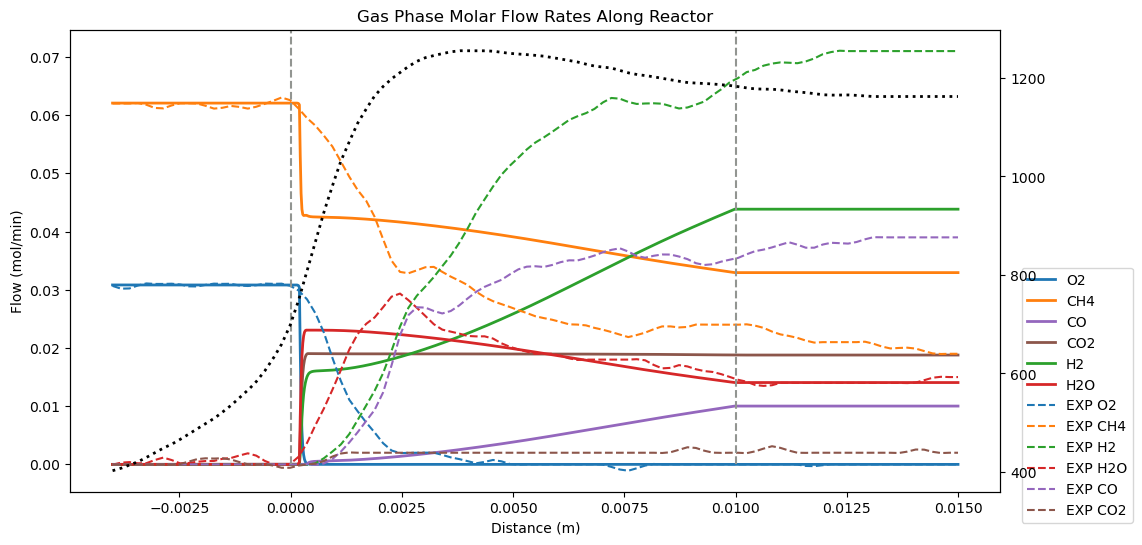

In [44]:
simulation.plot_gas_results(gas_out, gas)